# Lab2 - Concrete compressive strength regression (35 marks total)
Author: Steven Duong (30022492)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions (2 marks)

To find the best model, we follow the published article where root-mean squared error (rms) was used as a score function. The rms score function needs to be minimized, because the optimal score is 0, larger values are worse performances

In scikit-learn, only *maximization* is implemented. Hence, it is customary to maximize the *negative* rms. scitkit-learn provides a scoring function `neg_root_mean_squared_error`

In [2]:
from sklearn.model_selection import cross_validate


def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms)
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    scoring = ['neg_root_mean_squared_error']
    score_cv = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=scoring, return_train_score=True)

    mean_train = score_cv['train_' + scoring[0]].mean()
    mean_test = score_cv['test_' + scoring[0]].mean()

    return (mean_train, mean_test)
    

## 1. Load data (1 mark each for 3 total marks)
yellowbrick concrete  
https://www.scikit-yb.org/en/latest/api/datasets/concrete.html

Load the Dataset object with `load_concrete()` using `return_dataset=True`

Print the README of the Dataset object


In [10]:
from yellowbrick.datasets.loaders import load_concrete

# Load concrete dataset
concrete_data = load_concrete(return_dataset=True)

# Printing the README of the Dataset object
print(concrete_data.README)


# Concrete Compressive Strength

**Downloaded from the UCI Machine Learning Repository on October 13, 2016.**

- Multivariate Data Set
- Real Attributes
- 1,030 Instances
- 9 attributes
- Well suited for _regression_ tasks
- [https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Abstract

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

## Description

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

## Attributes

- cement (kg)
- blast furnace slag (kg)
- fly ash (kg)
- water (kg)
- superplasticizer (kg)
- coarse aggregate (kg)
- fine aggregate (kg)
- age (day)
- compressive strength (MPa)

## Citat

### *Question 1:* What is the target variable name and units in this dataset?

The target variable name is **concrete compressive strength** and the unit is **MPA**.


### 1.1 Prepare the feature matrix and target vector
Load the concrete data set into feature matrix `X` and target vector `y`

Print dimensions and type of `X`, `y`

In [17]:
# Load concrete dataset into feature matrix X and target vector y
X, y = concrete_data.to_data()

# Printing the dimensions and type of X and y
print(f"Dimensions of X:\n{X.shape}\nType of X:\n{type(X)}")
print(f"\nDimensions of y:\n{y.shape}\nType of y:\n{type(y)}")


Dimensions of X:
(1030, 8)
Type of X:
<class 'pandas.core.frame.DataFrame'>

Dimensions of y:
(1030,)
Type of y:
<class 'pandas.core.series.Series'>


## 2. Inspect the data (1 mark each for 4 total marks)

### 2.1 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features

Print the minimum and maximum of each feature in `X`

In [20]:
# Aggregating the data and printing the min and max of each feature.
# Transposing the table for better visualization.
X.aggregate(['min', 'max']).T


,min,max
cement,102.00,540.0
slag,0.00,359.4
ash,0.00,200.1
water,121.75,247.0
splast,0.00,32.2
coarse,801.00,1145.0
fine,594.00,992.6
age,1.00,365.0


### 2.2 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges

Add y-axis label indicating units, and a title

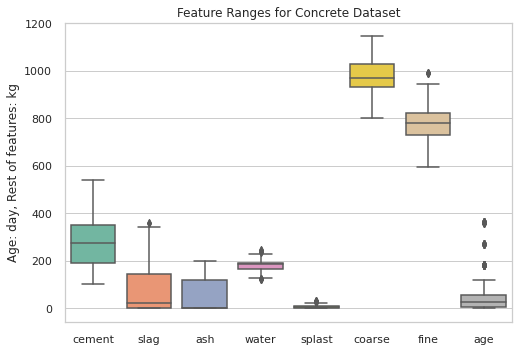

In [26]:
# Plotting using seaborn boxplot
import seaborn as sns

# Create a boxplot for each feature
sns.set(style="whitegrid")
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax.set_ylabel("Age: day, Rest of features: kg")
ax.set_title("Feature Ranges for Concrete Dataset");


### 2.3 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

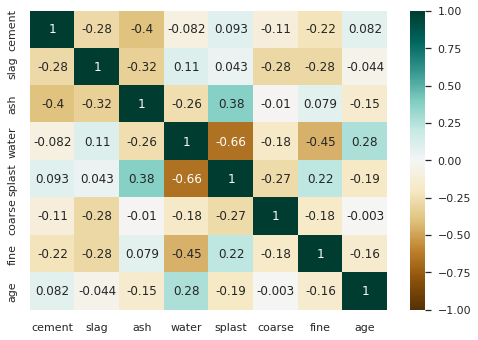

In [28]:
# Creating pairwise cross-correlation heatmap of features
X_corr = X.corr()

# Plotting the heatmap
sns.heatmap(data=X_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG');

### 2.4 Histogram of target variable 

To understand if all target values are equally represented in the data, we analyze how many samples of each target value we have available. The histogram of the target vector can visualize this distribution.

Using seaborn `displot()`, plot the histogram of the target vector. Add a title.

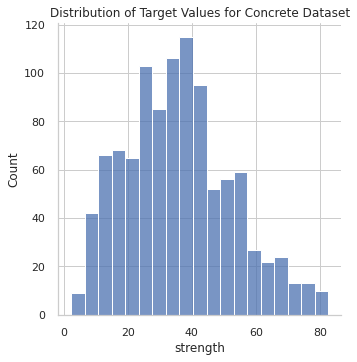

In [32]:
import matplotlib.pyplot as plt

# Plotting the histogram of the target vector
sns.displot(data=y)

# Adding the title
plt.title("Distribution of Target Values for Concrete Dataset");


## 3. Create training and test sets (1 mark)

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.2)


## 4. Compare models using cross-validation (3 marks)

Create a list containing a `LinearRegression()`, `RandomForestRegressor(random_state=64)` and `GradientBoostingRegressor(random_state=79)` objects.

Iterate this list and:
- using `X_train` and `y_train`
- compute the negative root mean-squared error using the `get_regressor_neg_rms()` function
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [46]:
# List of regression models
regression_models = [LinearRegression(), RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]

# Iterating the list of regression models
for model in regression_models:

  # Printing regression model label
  print(f"{model.__class__.__name__} model")

  # Calculating the training and test scores
  train_score, test_score = get_regressor_neg_rms(model, X_train, y_train, 7)

  # Printing the scores
  print(" 1. RMSE Training Score: {0:.2f}".format(train_score))
  print(" 2. RMSE Validation Score: {0:.2f}\n".format(test_score))


LinearRegression model
 1. RMSE Training Score: -10.29
 2. RMSE Validation Score: -10.39

RandomForestRegressor model
 1. RMSE Training Score: -2.12
 2. RMSE Validation Score: -4.97

GradientBoostingRegressor model
 1. RMSE Training Score: -3.69
 2. RMSE Validation Score: -4.98



### *Question 2:* For each of the three models, state if models are potentially over- or underfitting and why (3 marks)

1. **Linear Regression:** The model is potentially underfitting. This is due to the training and validation RMSE scores being very high (in negative terms). This means that the model complexity is low with high bias.

2. **RandomForestRegressor:** The model is potentially overfitting. This is due to the training RMSE score being noticeably better than the RMSE validation score with a high variance.

3. **GradientBoostingRegressor:** The model is potentially overfitting. This is due to the RMSE training score being lower than the validation RMSE score with a high variance.


## 5. Find a better model (3 marks)

Use the `RandomForestRegressor(random_state=64)` and find the best combination of `max_depth` from the list of `[10, 15, 20]`, and `n_estimators` from the list of `[100, 200, 400]`

Use nested for-loops to iterate these two lists:
- using `X_train` and `y_train`
- compute the negative root mean-squared error of the corresponding `RandomForestRegressor(random_state=64)` using the `get_regressor_neg_rms()` function 
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

Report the best validation score and the corresponding model

Note: We expect that more trees (larger `n_estimators`) yield better model performance

In [53]:
import pandas as pd

# List of hyperparameter values
max_depth = [10, 15, 20]
n_estimators = [100, 200, 400]

# Create an empty list to hold the results
results = []

for m in max_depth:
    for n in n_estimators:

        # Creating random forest regressor
        rfr = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=64)

        # negative RMSE scores
        train_score, test_score = get_regressor_neg_rms(rfr, X_train, y_train, 7)

        # Add the results to the list as a dictionary
        results.append({"max_depth": m, "n_estimators": n, "train_score": train_score, "test_score": test_score})

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(results)

# Format the train_score and test_score columns to 2 decimal places
df["train_score"] = df["train_score"].round(2)
df["test_score"] = df["test_score"].round(2)

# Print the DataFrame
print(df)

   max_depth  n_estimators  train_score  test_score
0         10           100        -2.44       -5.09
1         10           200        -2.42       -5.06
2         10           400        -2.41       -5.06
3         15           100        -2.12       -4.97
4         15           200        -2.11       -4.93
5         15           400        -2.10       -4.93
6         20           100        -2.12       -4.97
7         20           200        -2.11       -4.93
8         20           400        -2.09       -4.92


### *Question 3:* Which combination of `max_depth` and `n_estimators` produced the best validation score? Report both training and validation scores here (2 marks)

The following combinaion of max_depth and n_estimators procduced the best validaiton score:

**max_depth:** 20\
**n_estimators:** 400


## 6. Retrain best model (2 marks)

Create a `RandomForestRegressor(random_state=64)` with the best pair of `max_depth` and `n_estimators`, and retrain this model on all training data.

In [ ]:
#TODO: retrain the best estimator


## 7. Evaluate best model on training and test data
### 7.1 Root mean-squared error and $R^2$ (3 marks)

For the retrained best estimator, print the root mean-squared error (**2 decimal places**) and R-squared (**3 decimal places**) for training and test sets.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# TODO: print rms and r-squared for training and test set




### *Question 4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? Include scores in your answer. (2 marks)

*YOUR ANSWER HERE*


### 7.2 Predicted vs actual strength plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and actual strength on the y axis with data from the test set. With this plot, we can see where we make errors.

Add a line of unity (diagonal with slope 1 and offset 0). Ideally, all points would be on this line. We look for points being distributed equally around the line of unity.

Add x-axis, y-axis labels including units, and a title.


In [ ]:
#TODO: predicted-actual plot


### 7.3 Residual plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and the *difference* between actual and predicted strength on the y axis with data from the test set. This is an alternative way to see where errors are made.

We look for residuals being distributed equally around the zero horizontal line.

Add x-axis, y-axis labels including units, and a title.



In [ ]:
# TODO: Residual plot


## 8. Conclusion (3 marks)

In conclusion, comment on the following items:
1. Did we find a model that outperforms the polynomial regression reported in the reference article? Explain.
1. Did we find a model that outperforms the neural network reported in the reference article? Explain.
1. What were our assumption about the dataset and train/test split? How do these assumptions affect your conclusions?


*YOUR ANSWER HERE*


## 9. Reflection (2 marks)



Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

*ADD YOUR THOUGHTS HERE*

# Appendix-A: Bonus - use grid search to find the best model parameters
### (5 potential bonus marks)

## A-0. Workflow overview

In [ ]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## A-1. Hyperparameter tuning using grid search (2 marks)

The inital cross-validation above showed that both DecisionTree based models might have merit. Next, the hyperparameters are tuned using grid search.

### A-1.1 Grid search for RandomForestRegressor

Perform grid search using `GridSearchCV` for the `RandomForestRegressor(random_state=64)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 400]`
- `'max_depth': [ 15, 17, 19, 21]`
- `'max_features': ['auto', 'log2', None]`


In [ ]:
# TODO: Setup grid search for RandomForestRegressor(random_state=64)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### A-1.2 Grid search for gradient boosted tree

Perform grid search using `GridSearchCV` for the `GradientBoostingRegressor(random_state=79)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [1, 3, 5, 7]`
- `'learning_rate': [0.01, 0.1, 1.0]`

In [ ]:
# TODO: Setup grid search for GradientBoostingRegressor(random_state=79)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### *Question A-1:* Which of the two models produces the best score? What is the best score?

*YOUR ANSWER HERE*


## A-2. Retrain best model (1 mark)

Get the best estimator from the two grid searches above and retrain this model on all training data.

In [ ]:
#TODO: retrain the best estimator



## A-3. Model evaluation and conclusion (1 mark)

Repeat steps in Section 7 above for the best model.

Revisit your Question 4.

In [ ]:
#TODO: train and test set scores of retrained best model


In [ ]:
#TODO: predicted-actual plot


In [ ]:
# TODO: Residual plot


### *Question A-4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? (1 mark)

*YOUR ANSWER HERE*
